In [15]:
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from sklearn import preprocessing
np.random.seed(2017)
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [16]:
max_dim = 96
X_imp = np.empty((1584, max_dim, max_dim, 1))

for i in range(1,1585):
    x_img = load_img(os.path.join("images", str(i) + '.jpg'), grayscale=True)
    max_size = 0 if x_img.size[0] >= x_img.size[1] else 1 
    scale = max_dim/float(x_img.size[max_size])
    x_img = x_img.resize((int(x_img.size[0] * scale), int(x_img.size[1] * scale)))
    x_img = img_to_array(x_img)

    length = x_img.shape[0]
    width = x_img.shape[1]
    h1 = int((max_dim - length) / 2)
    h2 = h1 + length
    w1 = int((max_dim - width) / 2)
    w2 = w1 + width
    X_imp[i-1, h1:h2, w1:w2, 0:1] = x_img

X_imp = np.around(X_imp / 255.0)

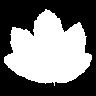

In [28]:
for i in range(0, 1):
    show_imp = array_to_img(X_imp[i, ])
    display(show_imp)

In [29]:
train_feature_data = pd.read_csv("train.csv")
test_feature_data = pd.read_csv("test.csv")

train_image_data = X_imp[train_feature_data['id']-1, ]
test_image_data = X_imp[test_feature_data['id']-1, ]

train_labels = train_feature_data['species']
le = preprocessing.LabelEncoder()
train_labels = le.fit(train_labels).transform(train_labels) 

X_train, X_val, y_train, y_val = train_test_split(train_image_data, train_labels, test_size=.3, random_state=42, stratify = train_labels)
y_train = (np.arange(99) == y_train[:,None]).astype(np.float32)
y_val = (np.arange(99) == y_val[:,None]).astype(np.float32)

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
test_image_data = test_image_data.astype(np.float32)

print("Training Image Data", X_train.shape, y_train.shape)
print("Validated Image Data", X_val.shape, y_val.shape)
print("Test Image Data", test_image_data.shape)

Training Image Data (693, 96, 96, 1) (693, 99)
Validated Image Data (297, 96, 96, 1) (297, 99)
Test Image Data (594, 96, 96, 1)


In [30]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


In [31]:
image_size = max_dim
num_labels = 99
num_channels = 1 # grayscale
batch_size = 32
lamb_reg = 0.0


graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_val)
    # tf_test_dataset = tf.constant(test_image_data)

    # Variables.
    layer1_weights = weight_variable([3, 3, 1, 64])
    layer1_biases = bias_variable([64])
    layer2_weights = weight_variable([3, 3, 64, 128])
    layer2_biases = bias_variable([128])
    layer3_weights = weight_variable([3, 3, 128, 256])
    layer3_biases = bias_variable([256])
    layer4_weights = weight_variable([12*12*256, 1024])
    layer4_biases = bias_variable([1024])
    layer5_weights = weight_variable([1024, 1024])
    layer5_biases = bias_variable([1024])
    layer6_weights = weight_variable([1024, num_labels])
    layer6_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        # Max pooling
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Normalization
        norm1 = tf.nn.lrn(pooled1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        # Dropout
        norm1 = tf.nn.dropout(norm1, proba)
        
        # Convolution
        conv2 = tf.nn.conv2d(norm1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        # Max pooling
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Normalization
        norm2 = tf.nn.lrn(pooled2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        # Dropout
        norm2 = tf.nn.dropout(norm2, proba)
        
        # Convolution
        conv3 = tf.nn.conv2d(norm2, layer3_weights, [1, 1, 1, 1], padding='SAME') + layer3_biases
        # Max pooling
        pooled3 = tf.nn.max_pool(tf.nn.relu(conv3), ksize=[1, 3, 3, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Normalization
        norm3 = tf.nn.lrn(pooled3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        # Dropout
        norm3 = tf.nn.dropout(norm3, proba)
        
        # Fully Connected Layer
        shape = layer4_weights.get_shape().as_list()
        reshape = tf.reshape(norm3, [-1, shape[0]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        full3 = tf.nn.relu(tf.matmul(full3, layer5_weights) + layer5_biases)

        return tf.matmul(full3, layer6_weights) + layer6_biases
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) + \
                    tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases) + \
                    tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases))

    # Add the regularization term to the loss.
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset,1.0))
    # test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [32]:
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = X_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), y_val)))
        # test_preds = test_prediction.eval().ravel()
        

In [34]:
run_session(5000, "AlexNet", 0.2)

Instructions for updating:
Please switch to tf.summary.merge_all.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at epoch 0: 4.603226184844971
Minibatch accuracy: 0.0
Validation accuracy: 1.0
Minibatch loss at epoch 500: 4.597929954528809
Minibatch accuracy: 3.1
Validation accuracy: 1.0
Minibatch loss at epoch 1000: 2.1633460521698
Minibatch accuracy: 21.9
Validation accuracy: 33.0
Minibatch loss at epoch 1500: 1.5744173526763916
Minibatch accuracy: 43.8
Validation accuracy: 50.8
Minibatch loss at epoch 2000: 1.2091810703277588
Minibatch accuracy: 53.1
Validation accuracy: 57.6
Minibatch loss at epoch 2500: 1.1706222295761108
Minibatch accuracy: 62.5
Validation accuracy: 60.9
Minibatch loss at epoch 3000: 0.7385767698287964
Minibatch accuracy: 68.8
Validation accuracy: 63.0


KeyboardInterrupt: 

32.0